# 공기압축기 이상탐지 프로젝트

---
1. 데이터 구성 항목은 다음과 같습니다.   
- air_inflow: 공기 흡입 유량 (^3/min)   
- air_end_temp: 공기 말단 온도 (°C)   
- out_pressure: 토출 압력 (Mpa)   
- motor_current: 모터 전류 (A)   
- motor_rpm: 모터 회전수 (rpm)   
- motor_temp: 모터 온도 (°C)   
- motor_vibe: 모터 진동 (mm/s)   
- type: 설비 번호   

2. 또한 설비별로 다음의 특성을 갖습니다.   
- 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)   
- 설비 번호 1: 20HP   
- 설비 번호 2: 10HP   
- 설비 번호 3: 50HP   

3. 제출양식   
0(정상) 또는 1(이상)

---
- train_data: 학습용 데이터로 모두 **정상 case**로 이루어진 데이터입니다.
- test_data: 평가용 데이터로 정상 case와 이상 case가 함께 포함되어 있는 데이터로, 예측 대상에 해당됩니다.
- answer_sample: test_data에 대하여 작성할 제출용 레이블 파일 양식입니다.

## 패키지 로드

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from tqdm import tqdm

from scipy import interpolate

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchsummary import summary

import plotnine # ggplot
from plotnine import *

In [2]:
import os

base_path = "/home/seon/workspace/competition/aifactory/anomaly_detection_comp"
pd.read_csv(os.path.join(base_path,"dataset/train_data.csv"))



,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0
...,...,...,...,...,...,...,...,...
2458,2.28,50.20,0.7,29.53,2416.0,66.84,3.34,7
2459,2.04,46.94,0.7,26.34,2155.0,63.94,3.20,7
2460,1.19,35.74,0.7,15.39,1259.0,53.99,2.70,7
2461,1.21,36.00,0.7,15.64,1280.0,54.22,2.71,7


In [3]:
train_data = pd.read_csv("./dataset/train_data.csv")
train_data

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0
...,...,...,...,...,...,...,...,...
2458,2.28,50.20,0.7,29.53,2416.0,66.84,3.34,7
2459,2.04,46.94,0.7,26.34,2155.0,63.94,3.20,7
2460,1.19,35.74,0.7,15.39,1259.0,53.99,2.70,7
2461,1.21,36.00,0.7,15.64,1280.0,54.22,2.71,7


In [4]:
test_data=pd.read_csv("./dataset/test_data.csv")
test_data

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,2.51,53.28,0.7,32.54,2662.0,69.58,3.48,0
1,2.66,55.24,0.7,34.45,2819.0,71.32,3.57,0
2,1.72,42.74,0.7,22.23,1819.0,60.21,3.01,0
3,2.20,49.15,0.7,28.50,2332.0,65.91,3.30,0
4,2.06,47.28,0.7,26.67,2182.0,64.24,3.21,0
...,...,...,...,...,...,...,...,...
7384,2.12,48.08,0.7,27.45,2246.0,64.96,3.25,7
7385,1.48,39.63,0.7,19.19,1570.0,57.44,2.87,7
7386,1.56,40.61,0.7,20.15,1649.0,58.32,2.92,7
7387,1.59,40.99,0.7,20.52,1679.0,58.66,2.93,7


## 데이터 전처리


In [6]:
# motor_vibe 이상치 제거
outlier_idx = train_data[train_data.motor_vibe > 6].index

train_data.drop(index=outlier_idx, inplace=True)
train_data.reset_index(drop=True, inplace=True)

2. 또한 설비별로 다음의 특성을 갖습니다.   
- 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)   
- 설비 번호 1: 20HP   
- 설비 번호 2: 10HP   
- 설비 번호 3: 50HP   


In [7]:
# type을 마력별로 대체

def type2hp(x):
    if x == 1:
        return 20
    elif x == 2:
        return 10
    elif x == 3:
        return 50
    else:
        return 30

train_data.type = train_data.type.apply(lambda x: type2hp(x))
test_data.type = test_data.type.apply(lambda x: type2hp(x))

In [8]:
# 컬럼순서 변경
train_data = train_data[['out_pressure', 'motor_vibe', 'air_inflow', 'motor_current' 
                         , 'motor_temp', 'air_end_temp', 'motor_rpm', 'type']]
test_data = test_data[['out_pressure', 'motor_vibe', 'air_inflow', 'motor_current' 
                         , 'motor_temp', 'air_end_temp', 'motor_rpm', 'type']]

## 데이터 정규화

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

def scaling(train, test, scaler):
    scaled_train = pd.DataFrame(scaler.fit_transform(train.iloc[:,:-1]), index=train.index, columns=train.columns[:-1])
    scaled_test = pd.DataFrame(scaler.transform(test.iloc[:,:-1]), index=test.index, columns=test.columns[:-1])

    scaled_train["type"] = train_data.type
    scaled_test["type"] = test_data.type

    return scaled_train, scaled_test

scaled_train, scaled_test = scaling(train_data, test_data, StandardScaler())
scaled_train

,out_pressure,motor_vibe,air_inflow,motor_current,motor_temp,air_end_temp,motor_rpm,type
0,-1.110223e-16,-0.626443,-0.451541,-0.514570,-0.910371,-0.917260,-1.007673,30
1,-1.110223e-16,0.636336,0.694479,0.796894,1.170323,1.175766,1.115975,30
2,-1.110223e-16,-0.333848,-0.185797,-0.206336,-0.422228,-0.426063,-0.509444,30
3,-1.110223e-16,0.081945,0.196209,0.226660,0.264504,0.265506,0.192144,30
4,-1.110223e-16,-0.333848,-0.194102,-0.212207,-0.431196,-0.435223,-0.518159,30
...,...,...,...,...,...,...,...,...
2442,-1.110223e-16,0.004947,0.121469,0.145932,0.136382,0.136123,0.061414,30
2443,-1.110223e-16,-0.210650,-0.077839,-0.088179,-0.235170,-0.237141,-0.317705,30
2444,-1.110223e-16,-0.980636,-0.783721,-0.891790,-1.509979,-1.519520,-1.619203,30
2445,-1.110223e-16,-0.965237,-0.767112,-0.873443,-1.480511,-1.489751,-1.588699,30


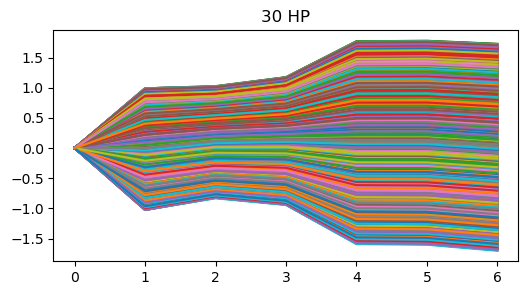

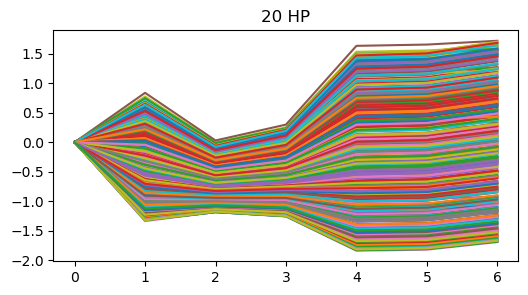

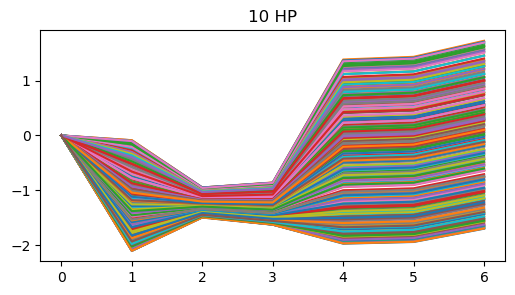

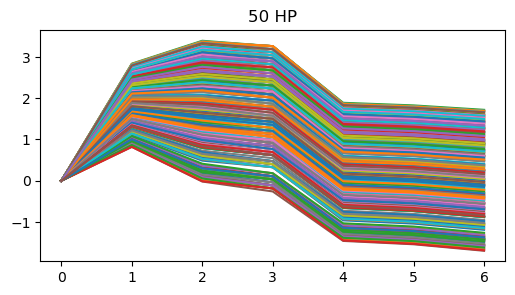

In [11]:
def plot_graph(dataframe, type):
    input_train = dataframe[dataframe.type == type]
    
    x = np.arange(7)
    plt.figure(figsize=(6,3))
    for i in range(len(input_train)):
        plt.plot(x, input_train.iloc[i,:-1])
    plt.title(f"{type} HP")
    plt.show()

for i in train_data.type.unique():
    plot_graph(scaled_train, i)

## AutoEncoder

In [12]:
class cfg:
    seed=1234
    gpu_idx = 0
    device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")

In [13]:
# AutoEncoder - basic
class AutoEncoder(nn.Module):
    def __init__(self, cfg):
        super(AutoEncoder, self).__init__()
        self.input_dim = cfg.input_dim
        self.dropout = cfg.dropout
        self.build_graph()
    
    def build_graph(self):
        self.encoding_layer = nn.Sequential(
            nn.Linear(cfg.input_dim, cfg.input_dim//2, bias=False),
            nn.Linear(cfg.input_dim//2, cfg.input_dim//4, bias=False),
            nn.Linear(cfg.input_dim//4, cfg.input_dim//8, bias=False),
            nn.Linear(cfg.input_dim//8, cfg.input_dim//16, bias=False),
            nn.Linear(cfg.input_dim//16, cfg.output_dim, bias=True)
        )

        self.decoding_layer = nn.Sequential(
            nn.Linear(cfg.output_dim, cfg.input_dim//16, bias=True),
            nn.Linear(cfg.input_dim//16, cfg.input_dim//8, bias=False),
            nn.Linear(cfg.input_dim//8, cfg.input_dim//4, bias=False),
            nn.Linear(cfg.input_dim//4, cfg.input_dim//2, bias=False),
            nn.Linear(cfg.input_dim//2, cfg.input_dim, bias=False)
        )
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, x):
        latent = self.encoding_layer(x)
        recon_input = self.decoding_layer(latent)
        return recon_input

### 학습에 필요한 데이터 셋 생성

In [14]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.features = data

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.features.iloc[idx,:-1])

### 학습 코드 생성

In [15]:
def update_avg(current_avg, val, idx):
    """현재 epoch 까지의 평균 값을 계산
    """
    return (current_avg * idx + val) / (idx + 1)

In [16]:
def train(cfg, train_dataloader, model, optimizer, criterion):
    model.train()
    
    current_loss_avg = 0.0
    
    # length = len(train_dataloader.dataset)
    bar = tqdm(train_dataloader, leave=False)
    for step, x in enumerate(bar):
        # grad 초기화
        optimizer.zero_grad()
        
        # 모델 forward
        x = x.to(cfg.device)
        x_hat = model(x)
        loss = criterion(x, x_hat)
        
        # 역전파
        loss.backward()
        
        # 최적화
        optimizer.step()
        if torch.isnan(loss):
            print('Loss NaN. Train Finish.')
            break
        current_loss_avg = update_avg(current_loss_avg, loss, step)
        
        # Msg
        msg = f"epoch: {cfg.epoch}, "
        msg += f"loss: {current_loss_avg.item():.5f}, "
        msg += f"lr: {optimizer.param_groups[0]['lr']:.6f}"
        bar.set_description(msg)
        
    results = {'losses': np.around(current_loss_avg.item(), 5)}
    return results

### 시각화

In [17]:
def eval(model, dataloader):
    scores = []
    model.eval()
    with torch.no_grad():
        for x in dataloader:
            x = x.to(cfg.device)
            x_hat = model(x)
            score = torch.mean(torch.abs(x - x_hat) , axis=1)
            scores.extend(score.cpu().numpy())
    return np.array(scores)

def plot_hist(train_scores, test_scores, threshold):
    # 히스토그램
    plt.hist(train_scores, bins=50, density=True, alpha=0.7, label='Train data')
    plt.hist(test_scores, bins=50, density=True, alpha=0.7, label='Test data')
    plt.axvline(x=threshold, c='red', linestyle=':', label='Threshold')
    plt.title("Score")
    plt.legend()
    plt.show()
    
def get_pred_label(model_pred, threshold):
    # (0:정상, 1:불량)로 Label 변환
    model_pred = np.where(model_pred <= threshold, 0, model_pred)
    model_pred = np.where(model_pred > threshold, 1, model_pred)
    return model_pred

### 모델 학습

- 하이퍼파라미터 설정 및 최적화 기법 설정

In [18]:
cfg.input_dim = 256 # 2의 배수로 설정하길 권장
cfg.output_dim = 6

cfg.batch_size=32
cfg.dropout = 0.05
cfg.epochs = 100
cfg.learning_rate=0.0001
cfg.reg_lambda = 0
cfg.check_epoch = 1

In [19]:
model = AutoEncoder(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
criterion = torch.nn.L1Loss() # L1Loss 등 다른 방안도 고려해볼것.

In [20]:
summary(model, [(1,cfg.input_dim)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]          32,768
            Linear-2                [-1, 1, 64]           8,192
            Linear-3                [-1, 1, 32]           2,048
            Linear-4                [-1, 1, 16]             512
            Linear-5                 [-1, 1, 6]             102
            Linear-6                [-1, 1, 16]             112
            Linear-7                [-1, 1, 32]             512
            Linear-8                [-1, 1, 64]           2,048
            Linear-9               [-1, 1, 128]           8,192
           Linear-10               [-1, 1, 256]          32,768
Total params: 87,254
Trainable params: 87,254
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.33
Estimated Tot

In [21]:
def get_scores(train_dataloader):

    total_logs = defaultdict(list) # default값이 list은 dictionary
    for epoch in range(cfg.epochs+1):   
        cfg.epoch = epoch
        train_results = train(cfg, train_dataloader, model, optimizer, criterion)
        
        for key, value in train_results.items():
            total_logs[key].append(value)
        
        if epoch == 0:
            print("Epoch", end=",")
            print(",".join(train_results.keys()))
        
        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in train_results.values()]))
        
    train_scores = pd.DataFrame({'Train Loss': total_logs['losses']})
    train_scores['Epoch'] = range(0, cfg.epochs+1, cfg.check_epoch)

    return train_scores

### OverSampling
- 7개의 feature를 늘림.

In [22]:
# OverSampling
def input_intp(df, input_num):
    x = np.arange(0, 7)
    y = df.iloc[:,:-1].values

    xnew = np.linspace(0, 6, input_num)
    ynew = [interpolate.interp1d(x, y[i], kind='linear')(xnew) for i in range(len(df))]
    ynew = pd.DataFrame(ynew, index=df.index)
    ynew["type"] = 30
    
    return ynew

input_intp(scaled_train[scaled_train.type == 30], cfg.input_dim)

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,type
0,-1.110223e-16,-0.014740,-0.029480,-0.044219,-0.058959,-0.073699,-0.088439,-0.103179,-0.117919,-0.132658,...,-0.990654,-0.992782,-0.994909,-0.997036,-0.999164,-1.001291,-1.003419,-1.005546,-1.007673,30
1,-1.110223e-16,0.014973,0.029945,0.044918,0.059890,0.074863,0.089836,0.104808,0.119781,0.134753,...,1.127230,1.125823,1.124416,1.123009,1.121602,1.120196,1.118789,1.117382,1.115975,30
2,-1.110223e-16,-0.007855,-0.015710,-0.023566,-0.031421,-0.039276,-0.047131,-0.054987,-0.062842,-0.070697,...,-0.493749,-0.495711,-0.497672,-0.499634,-0.501596,-0.503558,-0.505520,-0.507482,-0.509444,30
3,-1.110223e-16,0.001928,0.003856,0.005784,0.007712,0.009641,0.011569,0.013497,0.015425,0.017353,...,0.205954,0.204227,0.202501,0.200775,0.199049,0.197323,0.195597,0.193871,0.192144,30
4,-1.110223e-16,-0.007855,-0.015710,-0.023566,-0.031421,-0.039276,-0.047131,-0.054987,-0.062842,-0.070697,...,-0.502548,-0.504499,-0.506451,-0.508402,-0.510353,-0.512305,-0.514256,-0.516208,-0.518159,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442,-1.110223e-16,0.000116,0.000233,0.000349,0.000466,0.000582,0.000698,0.000815,0.000931,0.001048,...,0.075477,0.073719,0.071961,0.070203,0.068445,0.066687,0.064929,0.063172,0.061414,30
2443,-1.110223e-16,-0.004956,-0.009913,-0.014869,-0.019826,-0.024782,-0.029739,-0.034695,-0.039652,-0.044608,...,-0.302540,-0.304436,-0.306332,-0.308227,-0.310123,-0.312019,-0.313914,-0.315810,-0.317705,30
2444,-1.110223e-16,-0.023074,-0.046148,-0.069221,-0.092295,-0.115369,-0.138443,-0.161517,-0.184590,-0.207664,...,-1.600439,-1.602784,-1.605130,-1.607475,-1.609821,-1.612166,-1.614512,-1.616857,-1.619203,30
2445,-1.110223e-16,-0.022711,-0.045423,-0.068134,-0.090846,-0.113557,-0.136269,-0.158980,-0.181692,-0.204403,...,-1.570073,-1.572401,-1.574730,-1.577058,-1.579386,-1.581714,-1.584042,-1.586371,-1.588699,30


In [23]:
submission = pd.read_csv('./answer_sample.csv')
submission

,type,label
0,0,-1
1,0,-1
2,0,-1
3,0,-1
4,0,-1
...,...,...
7384,7,-1
7385,7,-1
7386,7,-1
7387,7,-1


#### 30HP

Epoch,losses
00  0.610550


01  0.610370


02  0.611310


03  0.610670


04  0.612100


05  0.610610


06  0.609190


07  0.593660


08  0.167270


09  0.038950


10  0.032460


11  0.031420


12  0.031500


13  0.031270


14  0.031350


15  0.031220


16  0.031140


17  0.031060


18  0.031170


19  0.031510


20  0.031040


21  0.030830


22  0.031060


23  0.031100


24  0.031250


25  0.031020


26  0.031680


27  0.031180


28  0.031170


29  0.031300


30  0.031170


31  0.031150


32  0.031700


33  0.032430


34  0.031070


35  0.031040


36  0.031270


37  0.031280


38  0.031040


39  0.031090


40  0.031380


41  0.031140


42  0.031070


43  0.030980


44  0.031130


45  0.031050


46  0.031110


47  0.031150


48  0.031360


49  0.031240


50  0.031100


51  0.031370


52  0.031430


53  0.031180


54  0.032030


55  0.031410


56  0.031430


57  0.031540


58  0.031250


59  0.031190


60  0.031270


61  0.031150


62  0.031080


63  0.031140


64  0.031090


65  0.031150


66  0.031060


67  0.031030


68  0.031270


69  0.031260


70  0.031160


71  0.031080


72  0.031450


73  0.031040


74  0.031330


75  0.031120


76  0.031350


77  0.031330


78  0.031530


79  0.030940


80  0.031500


81  0.031170


82  0.031390


83  0.031170


84  0.031030


85  0.031360


86  0.031180


87  0.031100


88  0.031640


89  0.031110


90  0.031420


91  0.031420


92  0.031980


93  0.031140


94  0.031060


95  0.031230


96  0.031780


97  0.031670


98  0.031130


99  0.031130


100  0.031320


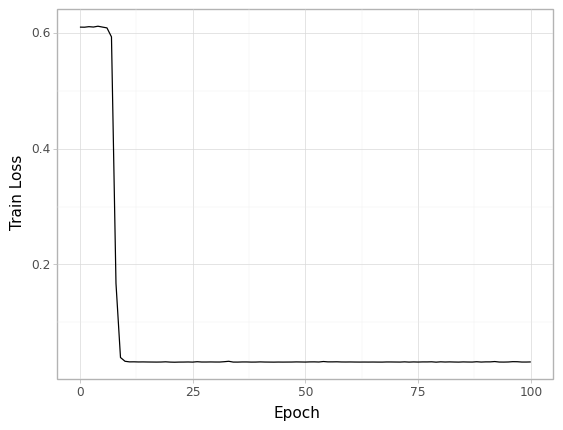

<ggplot: (8762388747463)>

In [24]:
hp_type = 30

input_train = scaled_train[scaled_train.type == hp_type]
input_test = scaled_test[scaled_test.type == hp_type]

input_train = input_intp(input_train, cfg.input_dim)
input_test = input_intp(input_test, cfg.input_dim)

model = AutoEncoder(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
criterion = torch.nn.L1Loss()

train_dataset=CustomDataset(input_train)
test_dataset=CustomDataset(input_test)

train_dataloader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False)
    
train_scores = get_scores(train_dataloader)
# plot loss func.
(
    ggplot(train_scores, aes(x='Epoch', y='Train Loss'))
        + geom_line(color='black')
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

(1422,)
(4266,)


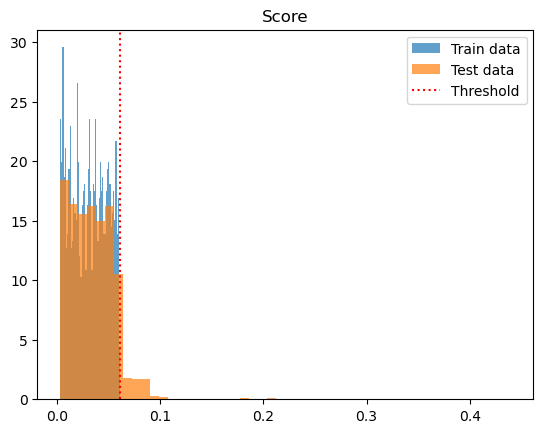

Counter({0.0: 4003, 1.0: 263})


In [25]:
with torch.no_grad():
    for j,x in enumerate(train_dataloader):
        x = x.to(cfg.device)
        optimizer.zero_grad()
        output = model.forward(x)
        break

train_scores = eval(model, train_dataloader)
print(train_scores.shape)
threshold=train_scores.max()

test_scores = eval(model, test_dataloader)
print(test_scores.shape)

plot_hist(train_scores, test_scores, threshold)
test_pred = get_pred_label(test_scores, threshold)
print(Counter(test_pred))

idx = input_test.index
submission.loc[idx, "label"] = test_pred

#### 20HP


Epoch,losses
00  0.615480


01  0.596900


02  0.648320


03  0.614640


04  0.625820


05  0.606140


06  0.642210


07  0.598010


08  0.677380


09  0.647370


10  0.594420


11  0.593090


12  0.588240


13  0.651820


14  0.538980


15  0.335740


16  0.315500


17  0.254820


18  0.238460


19  0.234370


20  0.193990


21  0.195930


22  0.215650


23  0.194620


24  0.179880


25  0.177660


26  0.176370


27  0.195600


28  0.177600


29  0.175760


30  0.182850


31  0.188070


32  0.182930


33  0.194050


34  0.190510


35  0.196850


36  0.175180


37  0.200970


38  0.185920


39  0.201800


40  0.193090


41  0.176080


42  0.206860


43  0.181130


44  0.205430


45  0.201180


46  0.191050


47  0.189930


48  0.179800


49  0.175200


50  0.192300


51  0.194220


52  0.198080


53  0.175630


54  0.191820


55  0.197620


56  0.176740


57  0.175680


58  0.174270


59  0.185810


60  0.176760


61  0.179020


62  0.181530


63  0.175880


64  0.203250


65  0.195520


66  0.183810


67  0.184560


68  0.188280


69  0.186130


70  0.196360


71  0.190020


72  0.181800


73  0.184480


74  0.185190


75  0.177110


76  0.186200


77  0.201480


78  0.187790


79  0.205420


80  0.173540


81  0.200860


82  0.176830


83  0.180110


84  0.206020


85  0.205730


86  0.200230


87  0.204350


88  0.174280


89  0.199200


90  0.191010


91  0.202950


92  0.185730


93  0.177510


94  0.199210


95  0.176160


96  0.178520


97  0.177440


98  0.182630


99  0.177380


100  0.201640


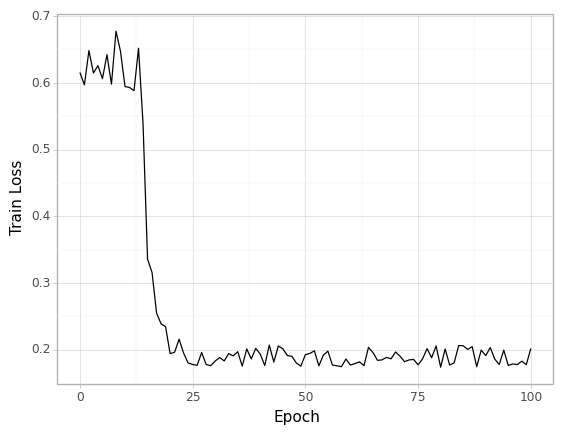

<ggplot: (8745659632785)>

In [27]:
hp_type = 20

input_train = scaled_train[scaled_train.type == hp_type]
input_test = scaled_test[scaled_test.type == hp_type]

input_train = input_intp(input_train, cfg.input_dim)
input_test = input_intp(input_test, cfg.input_dim)

model = AutoEncoder(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
criterion = torch.nn.L1Loss()

train_dataset=CustomDataset(input_train)
test_dataset=CustomDataset(input_test)

train_dataloader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False)
    
train_scores = get_scores(train_dataloader)
# plot loss func.
(
    ggplot(train_scores, aes(x='Epoch', y='Train Loss'))
        + geom_line(color='black')
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

(353,)
(1107,)


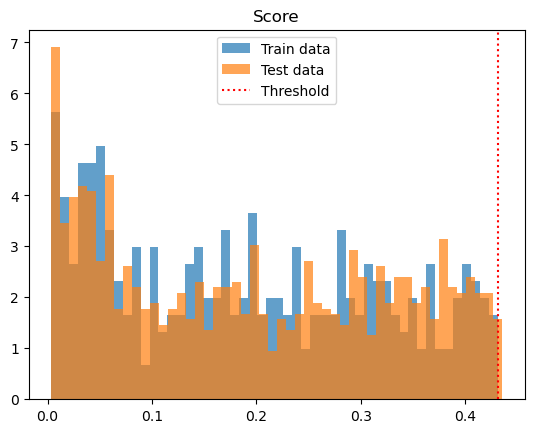

Counter({0.0: 1100, 1.0: 7})


In [28]:
with torch.no_grad():
    for j,x in enumerate(train_dataloader):
        x = x.to(cfg.device)
        optimizer.zero_grad()
        output = model.forward(x)
        break

train_scores = eval(model, train_dataloader)
print(train_scores.shape)
threshold=train_scores.max()

test_scores = eval(model, test_dataloader)
print(test_scores.shape)

plot_hist(train_scores, test_scores, threshold)
test_pred = get_pred_label(test_scores, threshold)
print(Counter(test_pred))

idx = input_test.index
submission.loc[idx, "label"] = test_pred

#### 10HP


Epoch,losses
00  0.944270


01  0.939000


02  0.942920


03  0.935100


04  0.945490


05  0.937350


06  0.945710


07  0.951750


08  0.947010


09  0.938810


10  0.936160


11  0.925110


12  0.887010


13  0.714790


14  0.456400


15  0.400210


16  0.372820


17  0.357320


18  0.350250


19  0.345110


20  0.342420


21  0.340880


22  0.335020


23  0.334000


24  0.337350


25  0.332610


26  0.332620


27  0.336170


28  0.335130


29  0.335080


30  0.336580


31  0.332230


32  0.337510


33  0.332810


34  0.341180


35  0.333240


36  0.335760


37  0.335630


38  0.334740


39  0.336740


40  0.333890


41  0.336720


42  0.335360


43  0.334990


44  0.337020


45  0.339860


46  0.333720


47  0.332130


48  0.334940


49  0.333640


50  0.337690


51  0.336540


52  0.332820


53  0.336310


54  0.333910


55  0.336500


56  0.338840


57  0.338640


58  0.335290


59  0.333310


60  0.337680


61  0.333580


62  0.336120


63  0.333680


64  0.332830


65  0.336150


66  0.336380


67  0.336140


68  0.331380


69  0.340510


70  0.333960


71  0.335980


72  0.332810


73  0.334440


74  0.335350


75  0.332910


76  0.334480


77  0.336710


78  0.336840


79  0.339890


80  0.332350


81  0.337310


82  0.336370


83  0.335160


84  0.339900


85  0.337110


86  0.332450


87  0.335900


88  0.331850


89  0.340170


90  0.333240


91  0.336560


92  0.336420


93  0.328270


94  0.336670


95  0.331900


96  0.334480


97  0.337050


98  0.337180


99  0.334590


100  0.340010


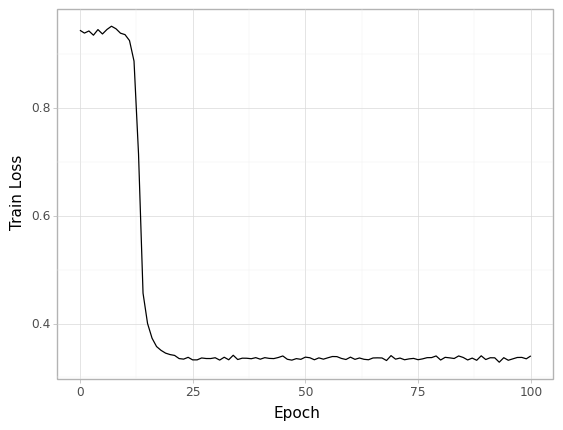

<ggplot: (8745659423380)>

In [29]:
hp_type = 10

input_train = scaled_train[scaled_train.type == hp_type]
input_test = scaled_test[scaled_test.type == hp_type]

input_train = input_intp(input_train, cfg.input_dim)
input_test = input_intp(input_test, cfg.input_dim)

model = AutoEncoder(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
criterion = torch.nn.L1Loss()

train_dataset=CustomDataset(input_train)
test_dataset=CustomDataset(input_test)

train_dataloader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False)
    
train_scores = get_scores(train_dataloader)
# plot loss func.
(
    ggplot(train_scores, aes(x='Epoch', y='Train Loss'))
        + geom_line(color='black')
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

(366,)
(1098,)


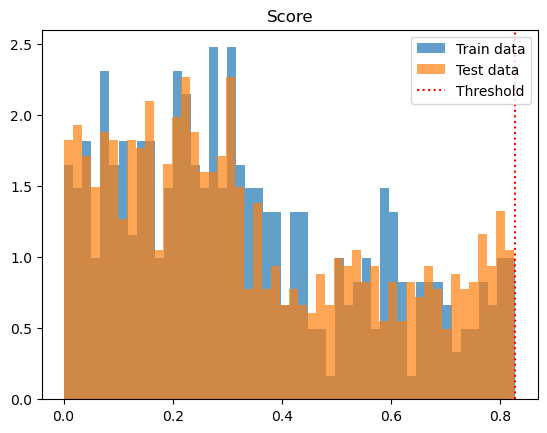

Counter({0.0: 1098})


In [30]:
with torch.no_grad():
    for j,x in enumerate(train_dataloader):
        x = x.to(cfg.device)
        optimizer.zero_grad()
        output = model.forward(x)
        break

train_scores = eval(model, train_dataloader)
print(train_scores.shape)
threshold=train_scores.max()

test_scores = eval(model, test_dataloader)
print(test_scores.shape)

plot_hist(train_scores, test_scores, threshold)
test_pred = get_pred_label(test_scores, threshold)
print(Counter(test_pred))

idx = input_test.index
submission.loc[idx, "label"] = test_pred

#### 50HP


Epoch,losses
00  1.232400


01  1.230000


02  1.232540


03  1.235170


04  1.222300


05  1.245220


06  1.236080


07  1.230430


08  1.234070


09  1.228350


10  1.233260


11  1.223280


12  1.230420


13  1.226120


14  1.204970


15  1.122570


16  0.871350


17  0.566250


18  0.463030


19  0.396880


20  0.370590


21  0.354380


22  0.344590


23  0.331810


24  0.325550


25  0.320250


26  0.318720


27  0.319750


28  0.320850


29  0.322400


30  0.319030


31  0.318730


32  0.324310


33  0.321170


34  0.320060


35  0.317170


36  0.317790


37  0.320230


38  0.319190


39  0.323630


40  0.318080


41  0.321460


42  0.323100


43  0.322800


44  0.324140


45  0.319410


46  0.319740


47  0.322230


48  0.322760


49  0.324310


50  0.318010


51  0.318110


52  0.320920


53  0.323840


54  0.319020


55  0.316560


56  0.322160


57  0.319180


58  0.322330


59  0.322370


60  0.323290


61  0.321710


62  0.317460


63  0.319950


64  0.320160


65  0.320960


66  0.318170


67  0.321880


68  0.318210


69  0.316530


70  0.324420


71  0.318810


72  0.319980


73  0.320580


74  0.321890


75  0.320410


76  0.319020


77  0.317670


78  0.321010


79  0.324430


80  0.319490


81  0.324680


82  0.320520


83  0.318470


84  0.322700


85  0.319380


86  0.318100


87  0.322230


88  0.321220


89  0.320030


90  0.320170


91  0.318280


92  0.319050


93  0.321050


94  0.320200


95  0.317600


96  0.320810


97  0.320630


98  0.317820


99  0.323830


100  0.320120


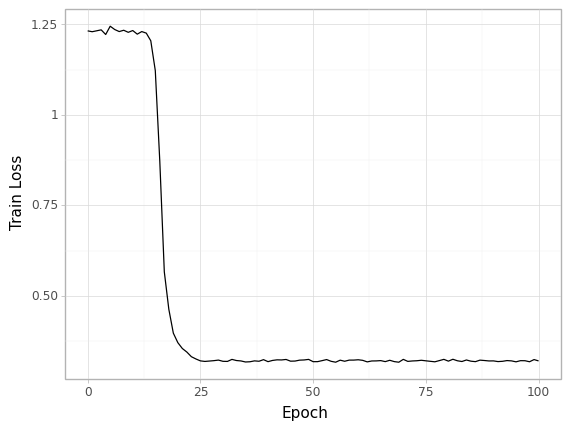

<ggplot: (8745658945756)>

In [31]:
hp_type = 50

input_train = scaled_train[scaled_train.type == hp_type]
input_test = scaled_test[scaled_test.type == hp_type]

input_train = input_intp(input_train, cfg.input_dim)
input_test = input_intp(input_test, cfg.input_dim)

model = AutoEncoder(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
criterion = torch.nn.L1Loss()

train_dataset=CustomDataset(input_train)
test_dataset=CustomDataset(input_test)

train_dataloader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False)
    
train_scores = get_scores(train_dataloader)
# plot loss func.
(
    ggplot(train_scores, aes(x='Epoch', y='Train Loss'))
        + geom_line(color='black')
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

(306,)
(918,)


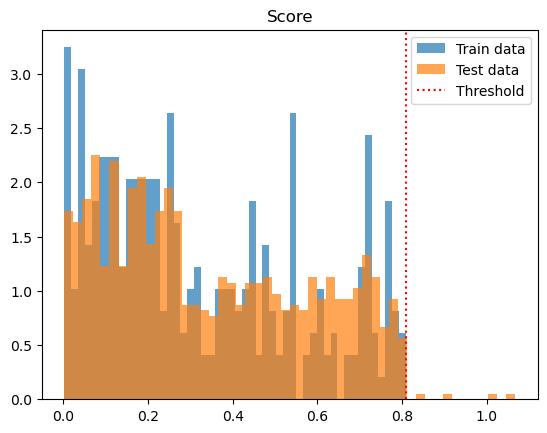

Counter({0.0: 913, 1.0: 5})


In [32]:
with torch.no_grad():
    for j,x in enumerate(train_dataloader):
        x = x.to(cfg.device)
        optimizer.zero_grad()
        output = model.forward(x)
        break

train_scores = eval(model, train_dataloader)
print(train_scores.shape)
threshold=train_scores.max()

test_scores = eval(model, test_dataloader)
print(test_scores.shape)

plot_hist(train_scores, test_scores, threshold)
test_pred = get_pred_label(test_scores, threshold)
print(Counter(test_pred))

idx = input_test.index
submission.loc[idx, "label"] = test_pred

## Submission

In [48]:
import pendulum
from datetime import datetime

t = pendulum.now()
t.strftime('%m%d%H%M')


'04062342'

In [33]:
submission

,type,label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
7384,7,0
7385,7,0
7386,7,0
7387,7,0


In [34]:
submission.label.value_counts()

0    7129
1     260
Name: label, dtype: int64

In [36]:
submission.to_csv("./submission/standard_oversampling_basicAE_062145.csv")